# 01 - EDA and Preprocessing

This notebook covers data loading, quality checks, EDA, feature engineering, preprocessing decisions, and train/test split export.

Name: Venkata Kiran Kuamr Guptha Nujella
Student ID: iitp_aiml_2506453

In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
os.getcwd()
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'Data').exists() and (p / 'requirements.txt').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_theme(style='whitegrid')
RANDOM_STATE = 42
DATA_PATH = PROJECT_ROOT / 'Data/german_credit_data.csv'


In [ ]:
# Validate project layout (helps avoid Colab path issues)
required_dirs = ['Data', 'Models', 'Visualizations', 'Report']
missing_dirs = [d for d in required_dirs if not (PROJECT_ROOT / d).exists()]
required_files = ['requirements.txt', 'Data/german_credit_data.csv']
missing_files = [f for f in required_files if not (PROJECT_ROOT / f).exists()]

if missing_dirs or missing_files:
    raise FileNotFoundError(
        'PROJECT_ROOT check failed. '        f'PROJECT_ROOT={PROJECT_ROOT}; '        f'missing_dirs={missing_dirs}; '        f'missing_files={missing_files}'
    )

print('Project layout OK:', PROJECT_ROOT)


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

TARGET_MAP = {'good': 0, 'bad': 1}
SCORE_MAP = {
    'unknown': 0,
    'little': 1,
    'moderate': 2,
    'quite rich': 3,
    'rich': 4,
}
HIGH_RISK_PURPOSES = {'education', 'business', 'repairs', 'vacation/others'}


def load_data(path):
    csv_path = Path(path)
    if not csv_path.exists():
        raise FileNotFoundError(f'Dataset not found at: {csv_path}')
    return pd.read_csv(csv_path)


def basic_data_report(df):
    return {
        'shape': df.shape,
        'dtypes': df.dtypes.astype(str).to_dict(),
        'missing_values': df.isna().sum().to_dict(),
        'duplicate_rows': int(df.duplicated().sum()),
    }


def clean_target(df, target_col='Risk', mapping=None):
    data = df.copy()
    label_map = mapping or TARGET_MAP
    if target_col not in data.columns:
        raise KeyError(f"Target column '{target_col}' not present in dataframe.")
    data[target_col] = data[target_col].astype(str).str.lower().map(label_map)
    if data[target_col].isna().any():
        raise ValueError('Target encoding produced NaN values. Check label mapping.')
    data[target_col] = data[target_col].astype(int)
    return data


def fill_missing_accounts(df, account_columns=('Saving accounts', 'Checking account'), fill_value='unknown'):
    data = df.copy()
    for col in account_columns:
        if col in data.columns:
            data[col] = data[col].fillna(fill_value)
    return data


def split_data(df, target_col='Risk', test_size=0.2, random_state=42):
    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not present in dataframe.")
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)


def save_splits(X_train, X_test, y_train, y_test, out_dir='Data'):
    output = Path(out_dir)
    output.mkdir(parents=True, exist_ok=True)
    X_train.to_csv(output / 'X_train.csv', index=False)
    X_test.to_csv(output / 'X_test.csv', index=False)
    y_train.to_frame(name='Risk').to_csv(output / 'y_train.csv', index=False)
    y_test.to_frame(name='Risk').to_csv(output / 'y_test.csv', index=False)


def add_credit_duration_ratio(df):
    data = df.copy()
    duration = data['Duration'].replace(0, np.nan)
    data['Credit_to_Duration_Ratio'] = data['Credit amount'] / duration
    data['Credit_to_Duration_Ratio'] = data['Credit_to_Duration_Ratio'].fillna(0.0)
    return data


def add_age_group(df):
    data = df.copy()
    bins = [17, 25, 35, 50, 120]
    labels = ['18-25', '26-35', '36-50', '50+']
    data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels)
    data['Age_Group'] = data['Age_Group'].astype(str)
    return data


def add_account_stability(df):
    data = df.copy()
    savings_score = data['Saving accounts'].map(SCORE_MAP).fillna(0)
    checking_score = data['Checking account'].map(SCORE_MAP).fillna(0)
    data['Account_Stability'] = savings_score + checking_score
    return data


def add_high_risk_purpose_flag(df):
    data = df.copy()
    normalized_purpose = data['Purpose'].astype(str).str.lower()
    data['High_Risk_Purpose'] = normalized_purpose.isin(HIGH_RISK_PURPOSES).astype(int)
    return data


def engineer_features(df):
    data = df.copy()
    data = add_credit_duration_ratio(data)
    data = add_age_group(data)
    data = add_account_stability(data)
    data = add_high_risk_purpose_flag(data)
    return data

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_theme(style='whitegrid')
RANDOM_STATE = 42


## 1. Load Dataset (with fallback synthetic generator)

In [3]:
def generate_synthetic_credit_data(n_samples: int = 1000, seed: int = 42) -> pd.DataFrame:
    np.random.seed(seed)

    data = {
        'Age': np.random.randint(18, 75, n_samples),
        'Sex': np.random.choice(['male', 'female'], n_samples),
        'Job': np.random.choice([0, 1, 2, 3], n_samples, p=[0.2, 0.4, 0.3, 0.1]),
        'Housing': np.random.choice(['own', 'rent', 'free'], n_samples, p=[0.6, 0.3, 0.1]),
        'Saving accounts': np.random.choice(
            ['little', 'moderate', 'quite rich', 'rich', np.nan],
            n_samples,
            p=[0.4, 0.3, 0.1, 0.1, 0.1],
        ),
        'Checking account': np.random.choice(
            ['little', 'moderate', 'rich', np.nan],
            n_samples,
            p=[0.5, 0.25, 0.15, 0.1],
        ),
        'Credit amount': np.random.randint(250, 20000, n_samples),
        'Duration': np.random.randint(4, 72, n_samples),
        'Purpose': np.random.choice(
            ['car', 'furniture', 'radio/TV', 'education', 'business', 'domestic appliances', 'repairs', 'vacation/others'],
            n_samples,
            p=[0.3, 0.15, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05],
        ),
    }

    def generate_risk(row: pd.Series) -> str:
        risk_score = 0
        if row['Age'] < 25:
            risk_score += 15
        elif row['Age'] > 60:
            risk_score += 10

        if row['Credit amount'] > 10000:
            risk_score += 20
        if row['Duration'] > 36:
            risk_score += 15

        if pd.isna(row['Saving accounts']) or row['Saving accounts'] == 'little':
            risk_score += 20
        if pd.isna(row['Checking account']) or row['Checking account'] == 'little':
            risk_score += 15

        if row['Job'] == 0:
            risk_score += 25

        risk_score += np.random.randint(-10, 10)
        return 'bad' if risk_score > 50 else 'good'

    df_syn = pd.DataFrame(data)
    df_syn['Risk'] = df_syn.apply(generate_risk, axis=1)
    return df_syn

if DATA_PATH.exists():
    df = load_data(DATA_PATH)
    print(f'Loaded dataset from: {DATA_PATH}')
else:
    DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
    df = generate_synthetic_credit_data(n_samples=1000, seed=RANDOM_STATE)
    df.to_csv(DATA_PATH, index=False)
    print(f'Dataset not found. Generated synthetic dataset at: {DATA_PATH}')

df.head()

Loaded dataset from: ../data/raw/german_credit_data.csv


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,56,male,1,own,little,moderate,6745,22,car,good
1,69,female,2,free,moderate,moderate,10437,70,car,good
2,46,male,3,own,quite rich,little,9763,8,car,good
3,32,female,1,own,moderate,little,18964,70,radio/TV,bad
4,60,male,2,own,moderate,little,17650,14,domestic appliances,good


## 2. Basic Exploration

In [4]:
report = basic_data_report(df)
print('Shape:', report['shape'])
print('\nData types:\n', pd.Series(report['dtypes']))
print('\nMissing values:\n', pd.Series(report['missing_values']))
print('\nDuplicate rows:', report['duplicate_rows'])

display(df.describe(include='all').T)

Shape: (1000, 10)

Data types:
 Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

Missing values:
 Age                  0
Sex                  0
Job                  0
Housing              0
Saving accounts     85
Checking account    95
Credit amount        0
Duration             0
Purpose              0
Risk                 0
dtype: int64

Duplicate rows: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1000.0,NaN,NaN,NaN,46.247,16.288072,18.0,33.0,46.0,60.25,74.0
Sex,1000,2,male,523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.306,0.901763,0.0,1.0,1.0,2.0,3.0
Housing,1000,3,own,589,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,915,4,little,412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,905,3,little,505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,9943.912,5626.476201,298.0,5021.25,9814.0,14785.5,19893.0
Duration,1000.0,NaN,NaN,NaN,36.81,19.334418,4.0,21.0,36.0,53.0,71.0
Purpose,1000,8,car,289,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,1000,2,good,656,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Required EDA Visualizations

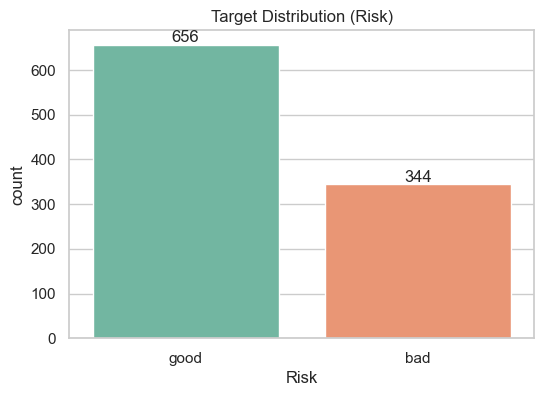

In [5]:
# Count plot of target variable
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Risk', palette='Set2')
ax.set_title('Target Distribution (Risk)')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

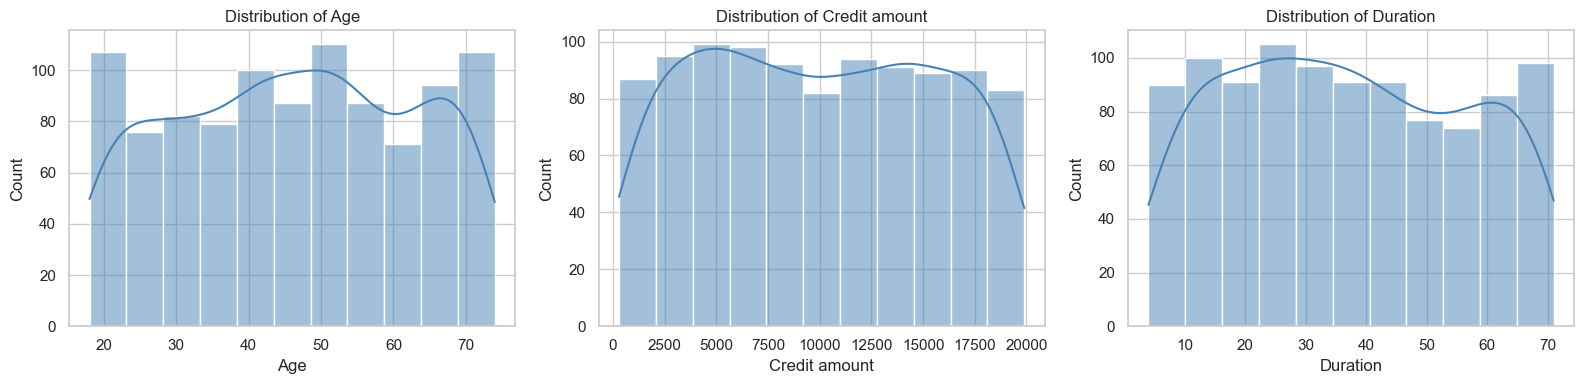

In [6]:
# Histograms for numerical columns
num_cols = ['Age', 'Credit amount', 'Duration']
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

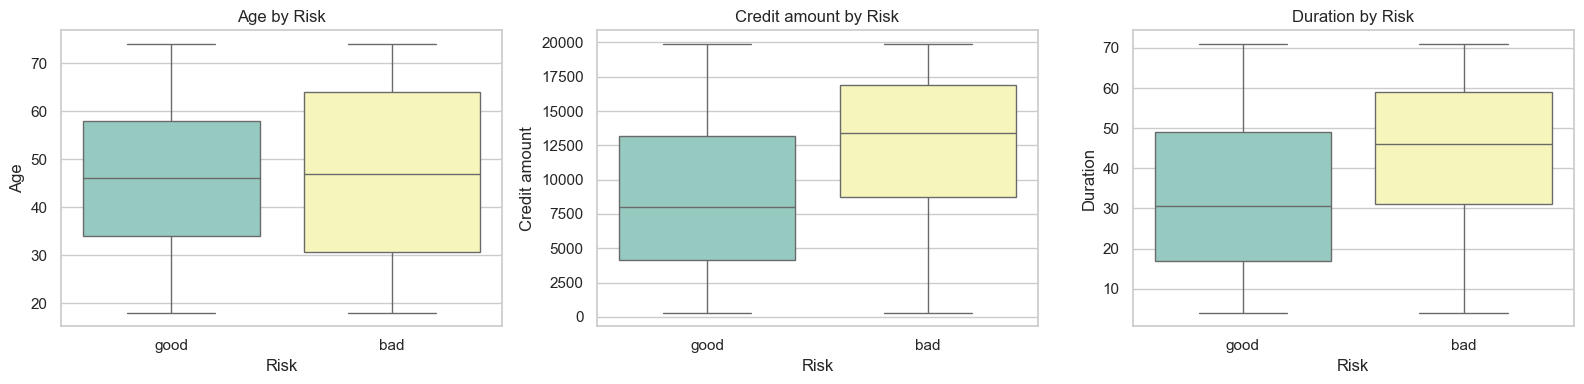

In [7]:
# Box plots by risk category
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='Risk', y=col, ax=axes[i], palette='Set3')
    axes[i].set_title(f'{col} by Risk')
plt.tight_layout()
plt.show()

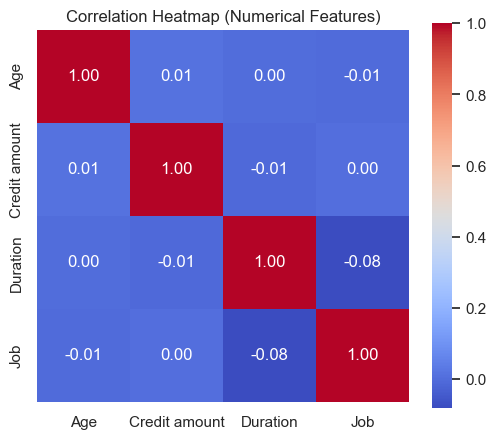

In [8]:
# Correlation heatmap for numerical features
corr = df[num_cols + ['Job']].corr(numeric_only=True)
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

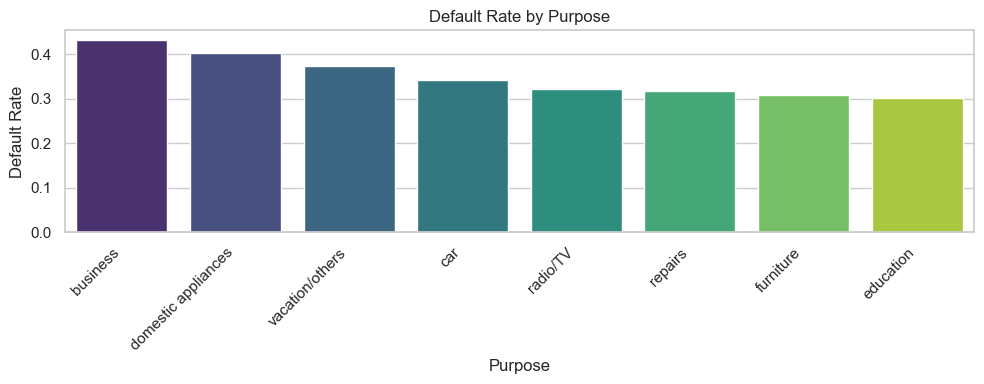

In [9]:
# Additional Insight 1: Default rate by loan purpose
purpose_default = (
    df.assign(Risk_bad=(df['Risk'].str.lower() == 'bad').astype(int))
      .groupby('Purpose', as_index=False)['Risk_bad']
      .mean()
      .sort_values('Risk_bad', ascending=False)
)

plt.figure(figsize=(10, 4))
sns.barplot(data=purpose_default, x='Purpose', y='Risk_bad', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Default Rate')
plt.title('Default Rate by Purpose')
plt.tight_layout()
plt.show()

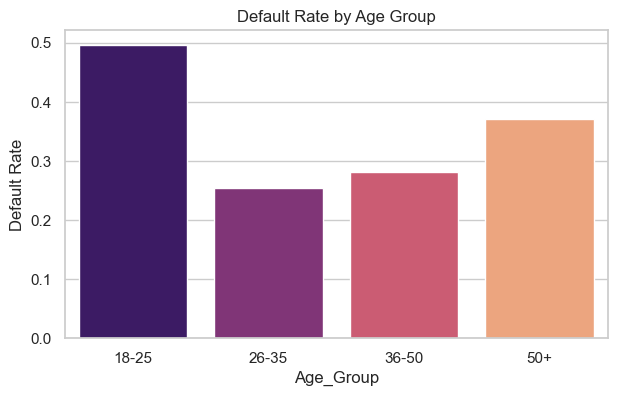

In [10]:
# Additional Insight 2: Default rate by age group
df_age = df.copy()
df_age['Age_Group'] = pd.cut(df_age['Age'], bins=[17, 25, 35, 50, 120], labels=['18-25', '26-35', '36-50', '50+'])
age_default = (
    df_age.assign(Risk_bad=(df_age['Risk'].str.lower() == 'bad').astype(int))
          .groupby('Age_Group', as_index=False)['Risk_bad']
          .mean()
)

plt.figure(figsize=(7, 4))
sns.barplot(data=age_default, x='Age_Group', y='Risk_bad', palette='magma')
plt.ylabel('Default Rate')
plt.title('Default Rate by Age Group')
plt.show()

## 4. Preprocessing and Feature Engineering

In [11]:
# 1) Impute missing values for account columns
df_clean = fill_missing_accounts(df)

# 2) Feature engineering
df_feat = engineer_features(df_clean)

# 3) Encode target: good=0, bad=1
df_final = clean_target(df_feat, target_col='Risk')

print('Final dataset shape:', df_final.shape)
display(df_final.head())
print('\nEngineered columns:', [
    c for c in ['Credit_to_Duration_Ratio', 'Age_Group', 'Account_Stability', 'High_Risk_Purpose'] if c in df_final.columns
])

Final dataset shape: (1000, 14)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Credit_to_Duration_Ratio,Age_Group,Account_Stability,High_Risk_Purpose
0,56,male,1,own,little,moderate,6745,22,car,0,306.590909,50+,3,0
1,69,female,2,free,moderate,moderate,10437,70,car,0,149.100000,50+,4,0
2,46,male,3,own,quite rich,little,9763,8,car,0,1220.375000,36-50,4,0
3,32,female,1,own,moderate,little,18964,70,radio/TV,1,270.914286,26-35,3,0
4,60,male,2,own,moderate,little,17650,14,domestic appliances,0,1260.714286,50+,3,0



Engineered columns: ['Credit_to_Duration_Ratio', 'Age_Group', 'Account_Stability', 'High_Risk_Purpose']


In [12]:
# Train-test split (80-20, random_state=42, stratified)
X_train, X_test, y_train, y_test = split_data(
    df_final,
    target_col='Risk',
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train distribution:\n', y_train.value_counts(normalize=True).rename('proportion'))
print('y_test distribution:\n', y_test.value_counts(normalize=True).rename('proportion'))

X_train: (800, 13) X_test: (200, 13)
y_train distribution:
 Risk
0    0.65625
1    0.34375
Name: proportion, dtype: float64
y_test distribution:
 Risk
0    0.655
1    0.345
Name: proportion, dtype: float64


In [13]:
# Demonstrate encoding + scaling pipeline (fit on train only)
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Transformed X_train shape:', X_train_transformed.shape)
print('Transformed X_test shape:', X_test_transformed.shape)

Transformed X_train shape: (800, 33)
Transformed X_test shape: (200, 33)


In [14]:
# Save processed split artifacts for downstream notebooks
save_splits(X_train, X_test, y_train, y_test, out_dir=PROJECT_ROOT / 'Data')


Saved: ../data/processed/X_train.csv, X_test.csv, y_train.csv, y_test.csv


## 5. Assumptions and Decisions

- Missing values in `Saving accounts` and `Checking account` are imputed as `unknown`.
- Target is encoded as `good=0`, `bad=1`.
- Feature engineering includes: `Credit_to_Duration_Ratio`, `Age_Group`, `Account_Stability`, and `High_Risk_Purpose`.
- Train-test split is stratified with `random_state=42` for reproducibility.
- Scaling and one-hot encoding are fit only on training data to avoid data leakage.